In [5]:
import csv
import ast
import heapq
from collections import defaultdict, deque
from functools import lru_cache
import time
import psutil  
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import json

print("Libraries are loaded 🚀")

Libraries are loaded 🚀


In [6]:
PATHFINDER_DIR = '/workspaces/T-AIA-901_par_1/pathfinder_try/'
with open(PATHFINDER_DIR + 'output/stations_info.json', 'r') as json_file:
    station_data = json.load(json_file)

def convert_to_dict(connected_to_str):
    try:
        list_of_dicts = ast.literal_eval(connected_to_str)
        return {str(item['station']): float("{:.2f}".format(item['distance'])) for item in list_of_dicts}
    except (ValueError, SyntaxError):
        print(f"Error converting data: {connected_to_str}")
        return None

connected_stations = {}
with open(PATHFINDER_DIR + '/output/adjacency_list_stations_uic.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file, delimiter=',')
    for row in reader:
        code_uic = str(row['CODE_UIC'])
        connected_stations[code_uic] = convert_to_dict(row['connected_to'])

print("Data is loaded 🚀")

Data is loaded 🚀


In [7]:
class Graph:
    def __init__(self):
        self.graph = defaultdict(dict)
    
    def add_edge(self, node1, node2, weight):
        self.graph[node1][node2] = weight
        self.graph[node2][node1] = weight
    
    def get_neighbors(self, node):
        return self.graph[node]
    
    def get_all_nodes(self):
        return self.graph.keys()

G = Graph()
for station, connections in connected_stations.items():
    for connected_station, distance in connections.items():
        G.add_edge(station, connected_station, distance)

print(f"Graph has {len(G.get_all_nodes())} nodes and {sum(len(neighbors) for neighbors in G.graph.values())} edges")

Graph has 3352 nodes and 100348 edges


In [8]:
class Pathfinder:
    def __init__(self, graph):
        self.graph = graph
    
    @lru_cache(maxsize=None)
    def heuristic(self, node1, node2):
        node1_coords = station_data[node1]['coordinates']
        node2_coords = station_data[node2]['coordinates']
        return geodesic(node1_coords, node2_coords).kilometers

    def path_code_to_object(self, path, verbose=False):
        return [station_data[station]['libelle'] if not verbose else station_data[station] for station in path]

    def reconstruct_path(self, came_from, current):
        total_path = [current]
        while current in came_from:
            current = came_from[current]
            total_path.insert(0, current)
        return self.path_code_to_object(total_path)

    def monitor_memory(self, process, peak_memory):
        current_memory = process.memory_info().rss
        return max(peak_memory, current_memory)

    def serialize_result(self, came_from, current_node, goal, distance, total_memory, start_time, end_time, tries):
        total_time = end_time - start_time
        average_node_time = total_time / tries if tries > 0 else 0
        memory_usage_mb = total_memory / (1024 ** 2) 

        return {
            "path": self.reconstruct_path(came_from, current_node),
            "distance": distance,
            "tries": tries,
            "time": total_time,
            "path_length": len(self.reconstruct_path(came_from, goal)),
            "memory_usage": round(memory_usage_mb, 6), 
            "max_memory_usage": psutil.virtual_memory().used / (1024 ** 2), 
            "explored_nodes": tries,
            "average_node_time": average_node_time
        }

    def a_star(self, start, goal):
        process = psutil.Process()
        start_memory = process.memory_info().rss
        peak_memory = start_memory
        
        start_time = time.time()
        open_set = [(0, start)]
        came_from = {}
        g_score = {node: float('inf') for node in self.graph.get_all_nodes()}
        g_score[start] = 0
        f_score = {node: float('inf') for node in self.graph.get_all_nodes()}
        f_score[start] = self.heuristic(start, goal)
        tries = 0
        visited_nodes = set()
        
        while open_set:
            tries += 1
            current_f, current_node = heapq.heappop(open_set)
            visited_nodes.add(current_node)

            peak_memory = self.monitor_memory(process, peak_memory)
            
            if current_node == goal:
                end_time = time.time()
                total_memory = peak_memory - start_memory
                return self.serialize_result(came_from, current_node, goal, g_score[goal], total_memory, start_time, end_time, tries)

            for neighbor, distance in self.graph.get_neighbors(current_node).items():
                tentative_g_score = g_score[current_node] + distance
                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current_node
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = g_score[neighbor] + self.heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
        return None

    def dijkstra(self, start, goal):
        process = psutil.Process()
        start_memory = process.memory_info().rss
        peak_memory = start_memory
        
        start_time = time.time()
        pq = [(0, start)]
        distances = {node: float('inf') for node in self.graph.get_all_nodes()}
        distances[start] = 0
        came_from = {}
        tries = 0
        visited_nodes = set()
        
        while pq:
            tries += 1
            current_distance, current_node = heapq.heappop(pq)
            visited_nodes.add(current_node)

            peak_memory = self.monitor_memory(process, peak_memory)
            
            if current_node == goal:
                end_time = time.time()
                total_memory = peak_memory - start_memory
                return self.serialize_result(came_from, current_node, goal, distances[goal], total_memory, start_time, end_time, tries)

            for neighbor, distance in self.graph.get_neighbors(current_node).items():
                tentative_distance = current_distance + distance
                if tentative_distance < distances[neighbor]:
                    distances[neighbor] = tentative_distance
                    came_from[neighbor] = current_node
                    heapq.heappush(pq, (tentative_distance, neighbor))
        return None

    def bfs(self, start, goal):
        process = psutil.Process()
        start_memory = process.memory_info().rss
        peak_memory = start_memory
        
        start_time = time.time()
        queue = deque([start])
        came_from = {}
        visited = {node: False for node in self.graph.get_all_nodes()}
        visited[start] = True
        tries = 0
        visited_nodes = set([start])
        
        while queue:
            tries += 1
            current_node = queue.popleft()

            peak_memory = self.monitor_memory(process, peak_memory)
            
            if current_node == goal:
                end_time = time.time()
                total_memory = peak_memory - start_memory
                return self.serialize_result(came_from, current_node, goal, -1, total_memory, start_time, end_time, tries)

            for neighbor in self.graph.get_neighbors(current_node):
                if not visited[neighbor]:
                    visited[neighbor] = True
                    came_from[neighbor] = current_node
                    queue.append(neighbor)
                    visited_nodes.add(neighbor)
        return None

    def bellman_ford(self, start, goal):
        process = psutil.Process()
        start_memory = process.memory_info().rss
        peak_memory = start_memory

        start_time = time.time()
        distances = {node: float('inf') for node in self.graph.get_all_nodes()}
        distances[start] = 0
        came_from = {}
        tries = 0

        for _ in range(len(self.graph.get_all_nodes()) - 1):
            tries += 1
            for node in self.graph.get_all_nodes():
                for neighbor, distance in self.graph.get_neighbors(node).items():
                    if distances[node] + distance < distances[neighbor]:
                        distances[neighbor] = distances[node] + distance
                        came_from[neighbor] = node

            peak_memory = self.monitor_memory(process, peak_memory)

        for node in self.graph.get_all_nodes():
            for neighbor, distance in self.graph.get_neighbors(node).items():
                if distances[node] + distance < distances[neighbor]:
                    return {"error": "Negative-weight cycle detected"}

        end_time = time.time()
        total_memory = peak_memory - start_memory
        return self.serialize_result(came_from, goal, goal, distances[goal], total_memory, start_time, end_time, tries)

    def dfs(self, start, goal):
        process = psutil.Process()
        start_memory = process.memory_info().rss
        peak_memory = start_memory

        start_time = time.time()
        stack = [(start, [start])]
        came_from = {}
        visited_nodes = set()
        tries = 0

        while stack:
            tries += 1
            (current_node, path) = stack.pop()
            visited_nodes.add(current_node)

            peak_memory = self.monitor_memory(process, peak_memory)

            if current_node == goal:
                end_time = time.time()
                total_memory = peak_memory - start_memory
                return self.serialize_result(came_from, current_node, goal, -1, total_memory, start_time, end_time, tries)

            for neighbor in self.graph.get_neighbors(current_node):
                if neighbor not in visited_nodes:
                    came_from[neighbor] = current_node
                    stack.append((neighbor, path + [neighbor]))

        return None

A* result: {'path': ['La Douzillère', 'Joué-lès-Tours', 'Bressuire', 'Chalonnes'], 'distance': 166.46999999999997, 'tries': 13, 'time': 0.00748443603515625, 'path_length': 4, 'memory_usage': 0.125, 'max_memory_usage': 4736.328125, 'explored_nodes': 13, 'average_node_time': 0.0005757258488581731}
Dijkstra result: {'path': ['La Douzillère', 'Joué-lès-Tours', 'Bressuire', 'Chalonnes'], 'distance': 166.46999999999997, 'tries': 55, 'time': 0.0014290809631347656, 'path_length': 4, 'memory_usage': 0.0, 'max_memory_usage': 4736.328125, 'explored_nodes': 55, 'average_node_time': 2.598329023881392e-05}
BFS result: {'path': ['La Douzillère', 'Joué-lès-Tours', 'Bressuire', 'Chalonnes'], 'distance': -1, 'tries': 51, 'time': 0.0011811256408691406, 'path_length': 4, 'memory_usage': 0.0, 'max_memory_usage': 4736.328125, 'explored_nodes': 51, 'average_node_time': 2.3159326291551778e-05}
Bellman-Ford result: {'path': ['La Douzillère', 'Joué-lès-Tours', 'Bressuire', 'Chalonnes'], 'distance': 166.46999999

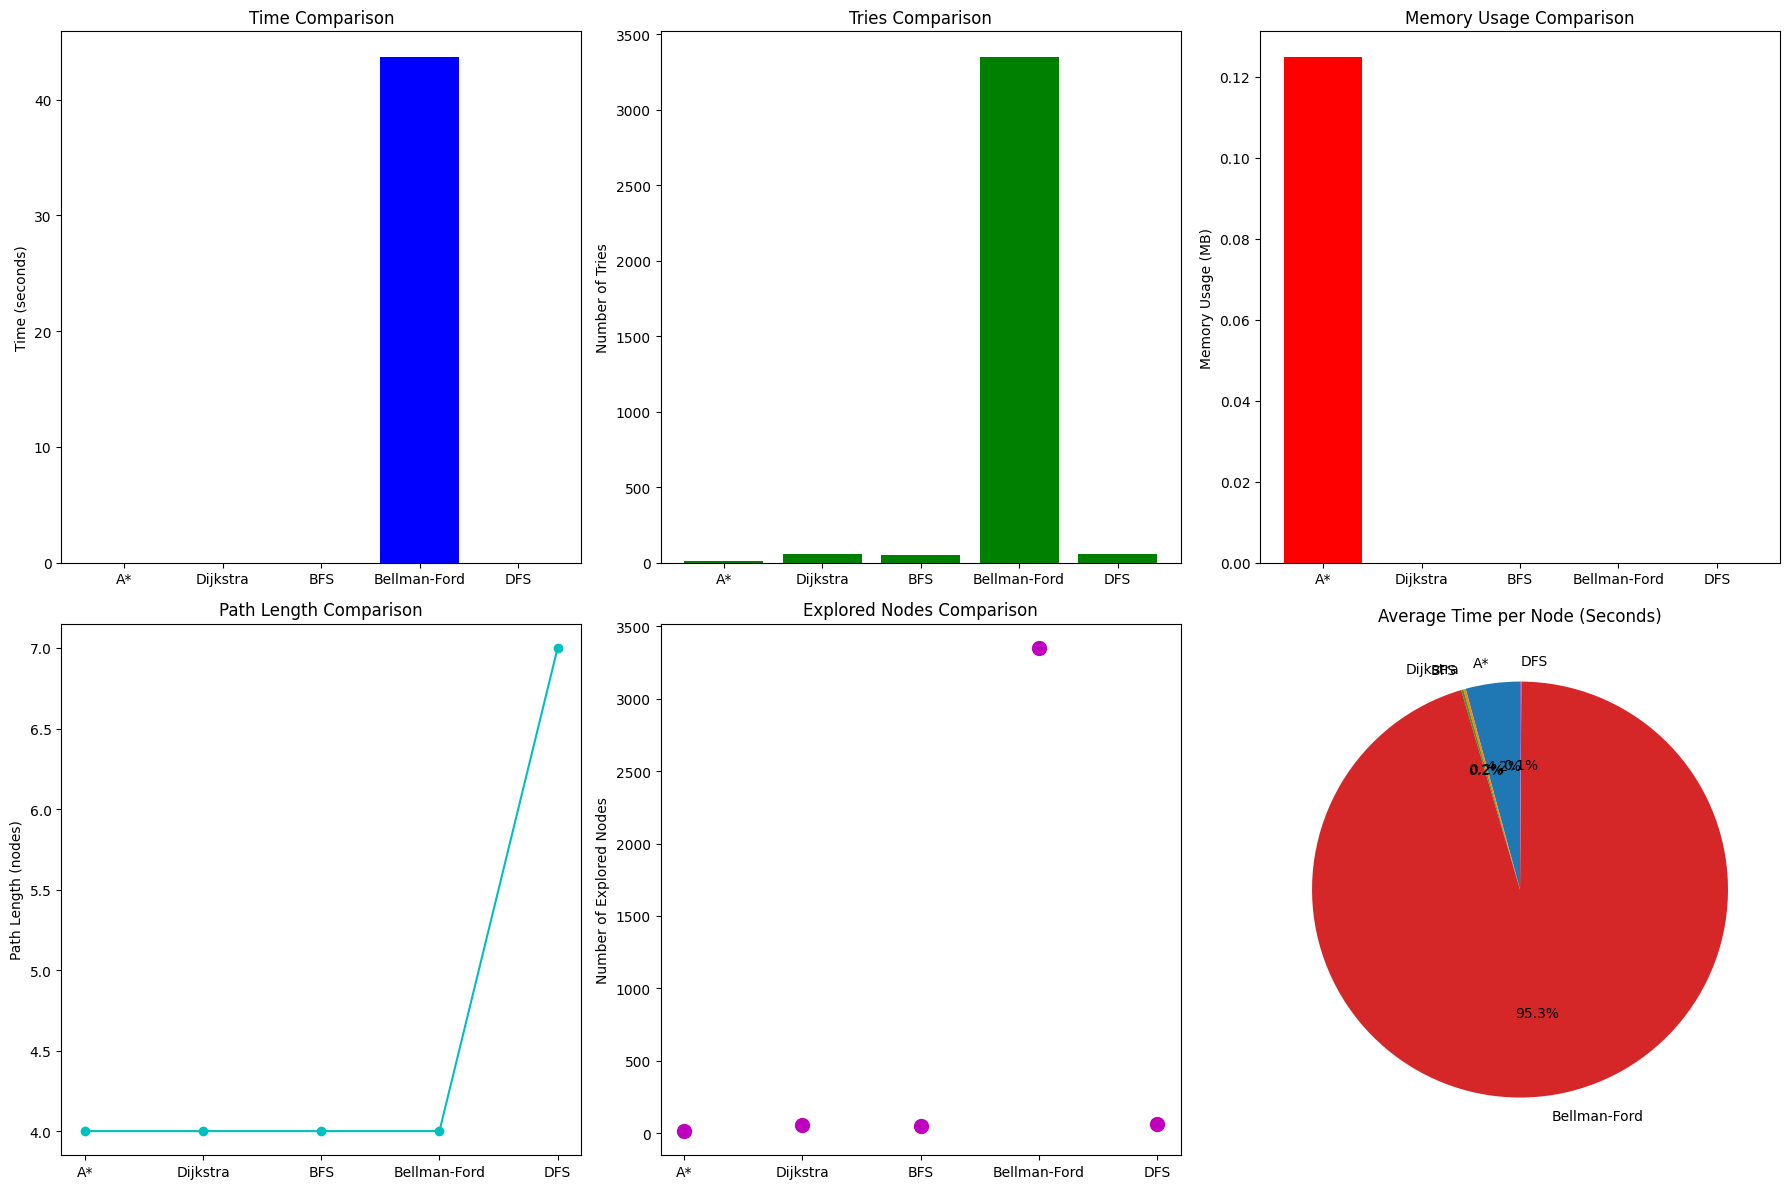

In [9]:

pathfinder = Pathfinder(G)
start_station = '87009696'
goal_station = '87484204'

a_star_result = pathfinder.a_star(start_station, goal_station)
print(f"A* result: {a_star_result}")

dijkstra_result = pathfinder.dijkstra(start_station, goal_station)
print(f"Dijkstra result: {dijkstra_result}")

bfs_result = pathfinder.bfs(start_station, goal_station)
print(f"BFS result: {bfs_result}")

bellman_ford_result = pathfinder.bellman_ford(start_station, goal_station)
print(f"Bellman-Ford result: {bellman_ford_result}")

dfs_result = pathfinder.dfs(start_station, goal_station)
print(f"DFS result: {dfs_result}")

def plot_results(results):
    algorithms = list(results.keys())
    times = [results[algo]['time'] for algo in algorithms]
    tries = [results[algo]['tries'] for algo in algorithms]
    memory_usages = [results[algo]['memory_usage'] for algo in algorithms]
    path_lengths = [results[algo]['path_length'] for algo in algorithms]
    explored_nodes = [results[algo]['explored_nodes'] for algo in algorithms]
    avg_node_times = [results[algo]['average_node_time'] for algo in algorithms]

    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    axs[0, 0].bar(algorithms, times, color='b')
    axs[0, 0].set_title('Time Comparison')
    axs[0, 0].set_ylabel('Time (seconds)')

    axs[0, 1].bar(algorithms, tries, color='g')
    axs[0, 1].set_title('Tries Comparison')
    axs[0, 1].set_ylabel('Number of Tries')

    axs[0, 2].bar(algorithms, memory_usages, color='r')
    axs[0, 2].set_title('Memory Usage Comparison')
    axs[0, 2].set_ylabel('Memory Usage (MB)')

    axs[1, 0].plot(algorithms, path_lengths, marker='o', linestyle='-', color='c')
    axs[1, 0].set_title('Path Length Comparison')
    axs[1, 0].set_ylabel('Path Length (nodes)')

    axs[1, 1].scatter(algorithms, explored_nodes, color='m', s=100)
    axs[1, 1].set_title('Explored Nodes Comparison')
    axs[1, 1].set_ylabel('Number of Explored Nodes')

    axs[1, 2].pie(avg_node_times, labels=algorithms, autopct='%1.1f%%', startangle=90)
    axs[1, 2].set_title('Average Time per Node (Seconds)')

    plt.tight_layout()
    plt.savefig("algorithm_comparison.png")
    plt.show()

results = {
    "A*": a_star_result,
    "Dijkstra": dijkstra_result,
    "BFS": bfs_result,
    "Bellman-Ford": bellman_ford_result,
    "DFS": dfs_result
}

plot_results(results)
